In [34]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/thesis/benchmarks

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/thesis/benchmarks


Second attempt at implementing a working BM3d algorithm, this is based on the work of this repository: https://github.com/Ryanshuai/BM3D_py

In [35]:
# Import libraries

import numpy as np
import cv2
from skimage.io import imread
from scipy.fftpack import dct, idct
from scipy.linalg import hadamard
import math
from matplotlib import pyplot as plt
#import pywt

Define the algorithm's hyperparameters

In [36]:
# Size of the padding to add to the image before each step of the BM3D
pad_size = 16

# Pixels to skip for finding a new reference block (speedup_factor)
sp_f = 3

# Variance of the gaussian noise
sigma = 20

# Threshold used to decide which block to keep
th_step1 = 2500 if sigma < 35 else 5000
th_step2 = 400 if sigma < 35 else 3500

# Maximum number of matching blocks for each step of the algo
max_b1 = 16
max_b2 = 32

# Threshold for hard thresholding in step 1
lambda3D = 2.7

useSD_H = False
useSD_W = True

# Type of transformation to use in each step
tau_2D_1 = 'DCT' # 'BIOR'
tau_2D_2 = 'DCT'

# Size of each block to search in the window
block_size = 8 if (tau_2D_1 == 'BIOR' or sigma < 40.) else 12

Import image and add noise

In [37]:
# rootfolder = 'c:/Users/Diego/uni/tesi/code_testing/data'
rootfolder = 'data'
png_to_open = 'Lena512.png'

img = imread(f'{rootfolder}/{png_to_open}')
imsz = img.shape

gaussian_noise = np.random.normal(0, sigma, imsz)
noisy_img = img + gaussian_noise

Introduce utility function to calculate psnr and plot images

In [38]:
def compute_psnr(gt_img, n_img):
    """
    Args:
        gt_img: Ground Thruth image from which we compute the mse
        n_img: Noisy image we want to calculate the psnr

    Returns:
        psnr: Value containing the Peak Signal to Noise Ratio of the noisy image
    """

    img_size = gt_img.shape

    n_img = n_img / 255
    gt_img = gt_img / 255

    if img_size != n_img.shape:
        print("PROBLEM: The 2 input images have different sizes!")
        return

    mse = 1/img_size[0]**2 * np.sum((gt_img - n_img)**2)
    psnr = 10 * math.log10(1/mse)

    n_img = n_img * 255
    gt_img = gt_img * 255

    return psnr

In [39]:
def plot_images(ground_truth, to_confront, psnr):
    """
    Function used to plot the clean image and the estimated clean one with its psnr

    Args:
        ground_truth: clean image
        to_confront: estimated clean image
        psnr: Peak Signal to Noise Ration of the estimate
    """

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(ground_truth, cmap='gray')
    ax[0].set_title('Original image')

    ax[1].imshow(to_confront, cmap='gray')
    ax[1].set_title(f'Noisy image, PSNR = {psnr:.2f}')

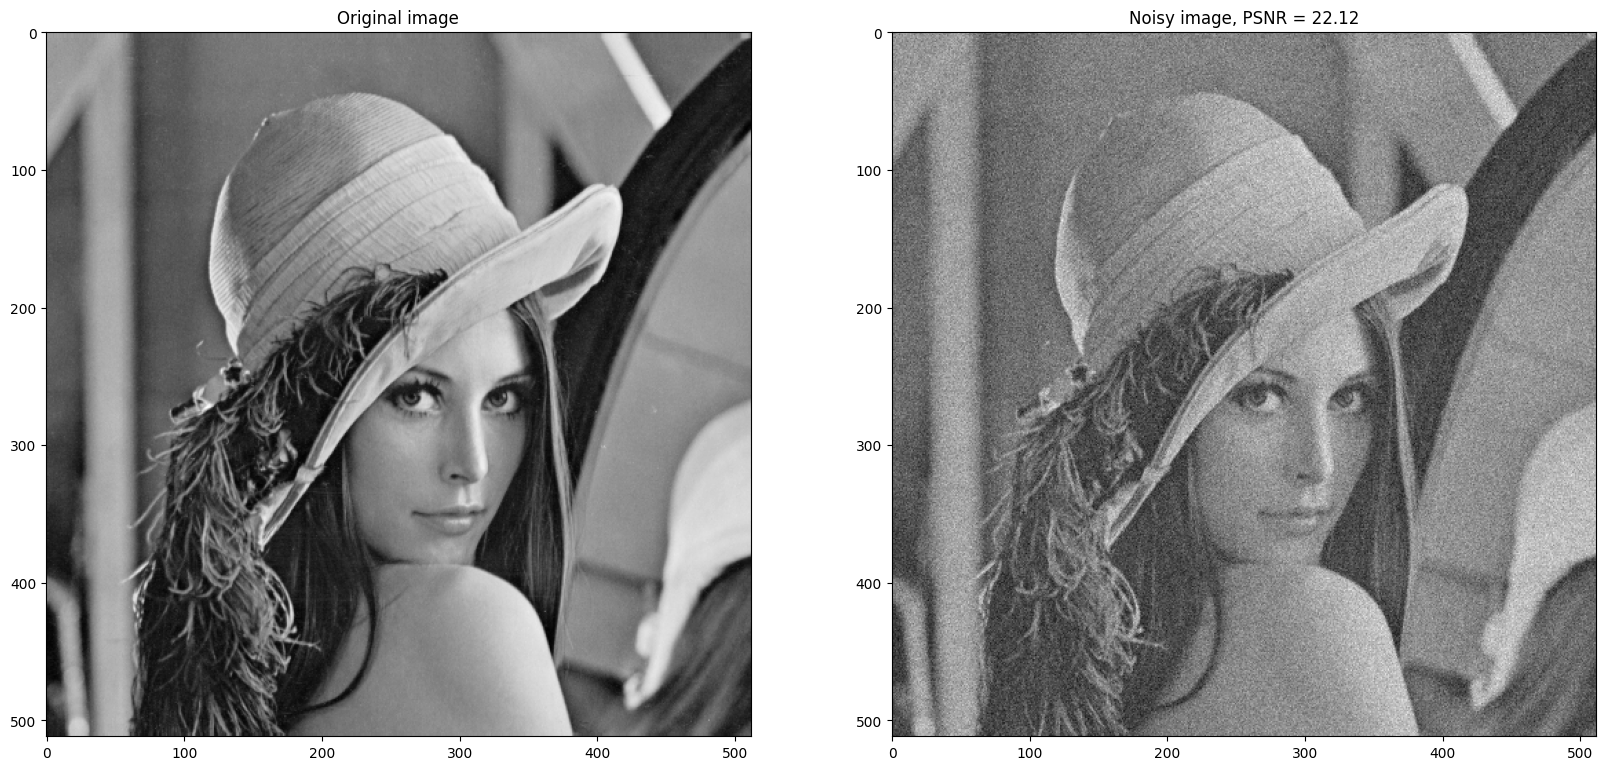

In [40]:
psnr_noisy = compute_psnr(img, noisy_img)
plot_images(img, noisy_img, psnr_noisy)

Introduce utility function for the algorithm itself

In [41]:
def add_sym_pad(img, pad_size):
    """
    Adds symmetric padding to an image.

    Args:
        img: Image to pad symmetrically
        pad_size: size of the padding

    Returns:
        img_pad: image padded
    """
    img_pad = np.pad(img, ((pad_size, pad_size), (pad_size, pad_size)), 'symmetric')
    return img_pad

In [42]:
def init_inds(last_coord, pad_size, step):
    """
    Returns a range containing indices that goes from 'pad_size' to 'last_coord-pad_size' with a step of 'step'

    Args:
        last_coord: last coordinate of the range
        pad_size: first coordinate of the range
        step: step of the range

    Returns:
        ind: range containing all the indices
    """
    ind = range(pad_size, last_coord - pad_size, step)
    if ind[-1] < last_coord - pad_size - 1:
        ind = np.append(ind, np.array([last_coord - pad_size - 1]), axis=0)

    return ind


In [43]:
def get_Kaiser_wind(b_s):
    """
    Produce a Kaiser window given the block size

    Args:
        b_s: size of the blocks of BM

    Returns:
        k_2d: initialized Kaiser window
    """

    k = np.kaiser(b_s, 2)
    k_2d = k[:, np.newaxis] @ k[np.newaxis, :]

    return k_2d

In [44]:
def img_to_blocks(img, bs):
    """Function used to divide an image into squared blocks. This avoid using nested for loops for the division of the blocks.

    Args:
        img: image to be divided
        bs: length of the side of a block in pixels

    Returns:
        The image divided into blocks of size bs
    """

    h, w = img.shape

    # Find the indices of the top rows of each possible block
    h_idx = np.arange(h - bs + 1)
    h_idx = h_idx[:, np.newaxis, np.newaxis, np.newaxis]

    # Find the indices of the top columns of each possible block
    w_idx = np.arange(w - bs + 1)
    w_idx = w_idx[np.newaxis, :, np.newaxis, np.newaxis]

    # Find the indices of the rows within each block
    block_h_idx = np.arange(bs)
    block_h_idx = block_h_idx[np.newaxis, np.newaxis, :, np.newaxis]

    # Find the indices of the columns within each block
    block_w_idx = np.arange(bs)
    block_w_idx = block_w_idx[np.newaxis, np.newaxis, np.newaxis, :]

    # Sum up the indices for rows and columns
    row_indices = h_idx + block_h_idx
    # print("r_idx: ", row_indices.shape)
    col_indices = w_idx + block_w_idx
    # print("c_idx: ", col_indices.shape)

    return img[row_indices, col_indices].astype(np.float64)

In [45]:
def sd_weighting(block_group):

    n = block_group.size

    mean = np.sum(block_group)
    std = np.sum(block_group * block_group)

    res = (std - mean * mean / n) / (n - 1)
    weight = 1.0 / np.sqrt(res) if res > 0. else 0.

    return weight

Define the functions for the forvard and backward 2D transformation, both DCt and BIOR

In [46]:
def last_transpose(vec):
    """Function that transposes the last 2 axes of a vector

    Args:
        vec: input vector

    Returns:
        vec: input vector with transposed axes
    """

    # Find the axes of the vector
    axes = list(range(vec.ndim))

    # invert the last 2
    axes[-1], axes[-2] = axes[-2], axes[-1]

    vec = vec.transpose(axes)
    return vec

def dct_2df(b):
    """Function that performs the 2D dct transform of the input

    Args:
        b: input block of the image

    Returns:
        b: blocked that has been transformed into his frequency domain
    """

    b = last_transpose(b)
    b = dct(b, norm='ortho')
    b = last_transpose(b)
    b = dct(b, norm='ortho')
    return b

def dct_2db(b):
    """Function that performs the inverse of the 2D dct transform. It brings the input block from the frequency domain to the image one.

    Args:
        b: input block

    Returns:
        b: input block that has been brought back to the image domain from the frequency one
    """
    b = last_transpose(b)
    b = idct(b, norm='ortho')
    b = last_transpose(b)
    b = idct(b, norm='ortho')
    return b

I'm having trouble with installing the PyWavelet package, thus I'll use the dct for now.

In [47]:
def bior_2df(M):

    max_iter = int(math.log2(M.shape[-1]))

    #coeffs = pywt.wavedec2(M, 'bior1.5', level=max_iter, mode='periodization')
    return

In [48]:
def bior_2db():
    return

Below I present the functions used for **STEP 1** of the algorithm

In [49]:
def trans_2d_mat(mat, right, down):
    """
    Apply translation to a matrix

    Args:
        mat: input matrix
        right: number of columns to translate to the right
        down: number of rows to translate down

    Returns:
        mat: translated matrix
    """

    mat = np.roll(mat, right, axis=1)
    mat = np.roll(mat, down, axis=0)
    return mat

In [50]:
def get_add_block_mat(h, w, w_hs, b_s):
    """Function used to generate the matrices: row_add_mat, col_add_mat. These are used to perform more efficiently the addition of blocks along rows and columns.
    The ides is that when computing the sum of squared differences between blocks, instead of iterating through each element of every block, you utilize these to
    efficiently perform the addition operation.

    Args:
        h: height
        w: width
        w_hs: size of half of the search window
        b_s: size of the edge of a block

    Returns:
        row_add_mat: matrix used to perform addition over the rows
        col_add_mat: matrix used to perform addition over the columns
    """

    row_add = np.eye(h - 2 * w_hs)
    row_add = np.pad(row_add, w_hs, 'constant')
    row_add_mat = row_add.copy()
    for k in range(1, b_s):
        row_add_mat += trans_2d_mat(row_add, right=k, down=0)

    col_add = np.eye(w - 2 * w_hs)
    col_add = np.pad(col_add, w_hs, 'constant')
    col_add_mat = col_add.copy()
    for k in range(1, b_s):
        col_add_mat += trans_2d_mat(col_add, right=0, down=k)

    return row_add_mat, col_add_mat

In [51]:
def closest_pw_2(mat, maximum):

    mat = np.where(maximum < mat, maximum, mat)
    while maximum > 1:
        mat = np.where((maximum // 2 < mat) * (mat < maximum), maximum // 2, mat)
        maximum //= 2
    return mat

In [52]:
def precompute_BM(img, b_s, max_b, wind_hside, th_match):
    """
    Function used to precompute block matching for the next steps

    Args:
        img: image from which we draw the matching blocks
        b_s: size of the blocks to search
        max_b: maximum number of matching blocks for reference
        wind_hside: dimension of half of the searching window
        th_match: threshold for block matching

    Returns:
        ref_coord: 4D array containing: (x, y) coords of the reference + (x, y) of the similar block
        th_count: counter containing the number of similar blocks found for reference
    """

    img = img.astype(np.float64)
    h, w = img.shape

    # Lenght of the side of the searching window
    wind_side = 2 * wind_hside + 1

    # Threshold for the distance decision, it is multiplied by the square of the size of the block to avoid the division when calculating the distances
    threshold = th_match * b_s * b_s

    # array that will store the matching scores between blocks
    sum_table = np.ones((wind_side, wind_side, h, w)) * 2 * threshold

    row_add_mat, col_add_mat = get_add_block_mat(h, w, wind_hside, b_s)

    # Matrix composed of a center of size (h - 2 * wind_hside, w - 2 * wind_hside) with value 1 and a margin of value 0.
    # It is used to ensure that the computation of the differences between blocks only occurs within the central region of the image, excluding the padding at the border.
    diff_margin = np.pad(np.ones((h - 2 * wind_hside, w - 2 * wind_hside)), wind_hside, 'constant', constant_values=0.)

    # Matrix of the same size of diff_margin that has elements different from 0 only on the padded region. It is used to avoid division by 0 in the next steps over the pixels in the padded margin
    sum_margin = (1 - diff_margin) * 2 * threshold

    for di in range(-wind_hside, wind_hside + 1):
        for dj in range(-wind_hside, wind_hside + 1):
            trans_img = trans_2d_mat(img, right=-dj, down=-di)
            # Compute the squared distances between the blocks
            diff_table_2 = (img - trans_img) * (img - trans_img) * diff_margin
            # matrix that contains the sum of squared differences for all possible displacements within the search window
            sum_diff_2 = row_add_mat @ diff_table_2 @ col_add_mat
            # make sure not to count the padded margin
            sum_table[di + wind_hside, dj + wind_hside] = np.maximum(sum_diff_2, sum_margin)

    sum_table = sum_table.reshape((wind_side * wind_side, h * w))
    sum_table_T = sum_table.transpose((1, 0))

    # Compute the sorting indices to find the top 'max_blocks' most similar blocks for each reference
    argsort = np.argpartition(sum_table_T, range(max_b))[:, :max_b]
    argsort[:, 0] = (wind_side * wind_side - 1) // 2

    # Compute the vertical and horizontal displacements between the reference block and the similar blocks
    argsort_di = argsort // wind_side - wind_hside
    argsort_dj = argsort % wind_side - wind_hside

    # Compute the pixel indices of the similar blocks, relative to the reference one, taking into account the displacements
    near_pi = argsort_di.reshape((h, w, -1)) + np.arange(h)[:, np.newaxis, np.newaxis]
    near_pj = argsort_dj.reshape((h, w, -1)) + np.arange(w)[np.newaxis, :, np.newaxis]

    # 4D array containing: (x, y) coords of the reference + (x, y) of the similar block
    ref_coord = np.concatenate((near_pi[:, :, :, np.newaxis], near_pj[:, :, :, np.newaxis]), axis=-1)

    # Count the number of similar blocks for each pixel in the image depending on the threshold
    # sum_filter is a mask that puts at 1 the values that are lower than the threshold and 0 the others
    sum_filter = np.where(sum_table_T < threshold, 1, 0)

    # Count the number of 1s in each column
    th_count = np.sum(sum_filter, axis=1)

    # For optimization purposes, make it such that the number of counted element is a power of 2
    th_count = closest_pw_2(th_count, maximum=max_b)
    th_count = th_count.reshape((h, w))

    return ref_coord, th_count

In [53]:
def build_group(blocks_dct, sim_pos, nsim_blocks):
    """Function that builds the 3D group of blocks similar to the current reference

    Args:
        blocks_dct: frequencies of all the blocks in the image
        sim_pos: (x,y) coordinates of the n similar blocks to the reference
        nsim_blocks: number of similar blocks found to the reference according to the used threshold

    Returns:
        block_group: 3D group containing the similar blocks to the reference in their frequency domain
    """

    # Find the size of a block (should be 8x8 or 12x12)
    a, b, c, d = blocks_dct.shape
    assert c == d

    block_group = np.zeros((nsim_blocks, c, c))
    for i in range(nsim_blocks):
        # Find the coordinates of the i-th block
        xi, yi = sim_pos[i]
        block_group[i, :, :] = blocks_dct[xi, yi]

    block_group = block_group.transpose((1, 2, 0))

    return block_group # the shape is inverted from before: (bs, bs, nsim_blocks)!!

In [54]:
def hadamard_trans(vec):
    """Function that performs the hadamard transformation on a vector

    Args:
        vec: input vector to transform

    Returns:
        vect: transformed vector
    """

    n = vec.shape[-1]
    h_mat = hadamard(n).astype(np.float64)
    vect = vec @ h_mat
    return vect

In [55]:
def ht_filtering_hadamard(group, sigma, lambda3D, do_weight):
    """
    Function that performs the hard thresholding of a group of similar blocks.
    It also calculates the weights for normalization.

    Args:
        group: group of similar patches to the current reference
        sigma: variance of the noise
        lambda3D: threshold base
        do_weight: boolean for weights calculation

    Returns:
        group: The hard thresholded group
        weight: weight for the current group
    """

    nsim_blocks = group.shape[-1]
    coef_norm = math.sqrt(nsim_blocks)
    coef = 1.0 / nsim_blocks

    # Perform hadamard transformation
    h_group = hadamard_trans(group)

    # Do Hard thresholding
    th = lambda3D * sigma * coef_norm
    th_weight = np.where(np.abs(h_group) > th, 1, 0)
    weight = np.sum(th_weight)
    # Apply hard thresholding
    h_group = np.where(np.abs(h_group)  > th, h_group, 0.)

    group = hadamard_trans(h_group)

    group *= coef
    if do_weight:
        weight = 1.0 / (sigma * sigma * weight) if weight > 0. else 1.

    return group, weight

In [56]:
def BM3D_step1(n_img):
    """Function that computes the first step of the BM3D algorithm

    Args:
        n_img: Input noisy image to denoise

    Returns:
        basi_estimate: Basic estimate of the clean image produced after hard thresholding
    """

    height, width = n_img.shape[0], n_img.shape[1]

    # Find all the coordinates of the pixels to predict in a range format
    row_inds = init_inds(height - block_size + 1, pad_size, sp_f)
    col_inds = init_inds(width - block_size + 1, pad_size, sp_f)

    # Initialize the Kaiser window
    kaiser_wind = get_Kaiser_wind(block_size)

    # ========== Grouping and filtering parts  ========== #

    # Precompute BM over the noisy image
    ref_coord, th_count = precompute_BM(n_img, block_size, max_b1, pad_size, th_step1)

    group_length = int(np.sum(th_count))

    # Initialize the matrix that will contain the matching groups
    block_group_mat = np.zeros((group_length, block_size, block_size))

    # Initialize the weight matrix
    weight_mat = np.zeros((height, width))

    # Find all the blocks from the noisy image and perform the 2D transform to find the frequencies
    all_blocks = img_to_blocks(n_img, block_size)
    if tau_2D_1 == 'DCT':
        all_blocks_dct = dct_2df(all_blocks)
    else:
        all_blocks_dct = bior_2df(all_blocks)

    pointer = 0
    for r in row_inds:
        for c in col_inds:
            # Find the num of similar blocks for the current reference
            nsim_blocks = th_count[r, c]

            # Build the reference's block group
            block_group = build_group(all_blocks_dct, ref_coord[r, c], nsim_blocks)
            block_group, weight = ht_filtering_hadamard(block_group, sigma, lambda3D, not useSD_H)
            block_group = block_group.transpose((2, 0, 1))

            # Fill the block group matrix with the current block group and update the pointer
            block_group_mat[pointer:pointer + nsim_blocks] = block_group
            pointer += nsim_blocks

            if useSD_H:
                weight = sd_weighting(block_group)

            # Update the weight matrix with the current weights
            weight_mat[r, c] = weight


    # Reverse the 2D transform
    if tau_2D_1 == 'DCT':
        block_group_mat = dct_2db(block_group_mat)
    else:
        block_group_mat = bior_2db(block_group_mat)

    # ========== Aggregation part  ========== #

    # Initialization
    num = np.zeros_like(n_img, dtype=np.float64)
    den = np.zeros((n_img.shape[0] - 2 * pad_size, n_img.shape[1] - 2 * pad_size), dtype=np.float64)
    den = np.pad(den, pad_size, 'constant', constant_values=1.0)

    pointer = 0

    # Iterate throught all the reference points of the image
    for r in row_inds:
        for c in col_inds:
            # Number of similar blocks to the reference
            nsim_blocks = th_count[r, c]

            # Position of the similar blocks to the reference
            sim_pos = ref_coord[r, c]

            # Find the current group and its weights
            group = block_group_mat[pointer:pointer + nsim_blocks]
            weight = weight_mat[r, c]

            # Update pointer for next iter
            pointer += nsim_blocks

            # For each similar block, extract the right patch and prepare the basic estimate to be divided by the weights
            for i in range(nsim_blocks):
                xi, yi = sim_pos[i]
                block = group[i]

                num[xi:xi+block_size, yi:yi+block_size] += block * kaiser_wind * weight
                den[xi:xi+block_size, yi:yi+block_size] += kaiser_wind * weight

    basic_estimate = num / den

    return basic_estimate

Below I present the function used in the **STEP 2** of the algorithm

In [57]:
def weiner_filtering_had(n_group, b_group, do_weight):
    """
    Function that performs Weiner filtering over the noisy groups given the basic estimate ones are counted as an effective clean image.

    Args:
        n_group: Group of noisy blocks similar to the current reference in their frequency domain
        b_group: Group of basic blocks similar to the current reference in their frequency domain
        do_weight: Boolean used to decide to compute the weight in a way or the other

    Returns:
        b_group: Group of the basic estimate to which Weiner filter is applied
        weight: the calculated weights
    """

    # Find the number of similar blocks to the reference one
    nsim_blocks = n_group.shape[-1]

    # Init coefficient
    coef = 1.0 / nsim_blocks

    # Perform the Hadamard transform on both the groups
    hn_group = hadamard_trans(n_group)
    hb_group = hadamard_trans(b_group)

    # Perform Weiner filtering
    val = np.power(hb_group, 2) * coef
    val /= (val + sigma * sigma)
    hb_group = hn_group * val * coef
    weight = np.sum(val)

    # Perform the Hadamard transform for the basic image group
    b_group = hadamard_trans(hb_group)

    if do_weight:
        weight = 1.0 / (sigma * sigma * weight) if weight > 0.0 else 1.0

    return b_group, weight

In [58]:
def BM3D_step2(noisy_img, basic_img):

    height, width = noisy_img.shape[0], noisy_img.shape[1]

    # Find all the coordinates of the pixels to predict in a range format
    row_inds = init_inds(height - block_size + 1, pad_size, sp_f)
    col_inds = init_inds(width - block_size + 1, pad_size, sp_f)

    # Init kaiser window
    kaiser_wind = get_Kaiser_wind(block_size)

    # ========== Grouping and filtering parts  ========== #

    # Precompute BM over the basic image
    ref_coord, th_count = precompute_BM(basic_img, block_size, max_b2, pad_size, th_step2)

    group_length = int(np.sum(th_count))

    # Initialize the matrix that will contain the matching groups
    block_group_mat = np.zeros((group_length, block_size, block_size))

    # Initialize the weight matrix
    weight_mat = np.zeros((height, width))

    # Find all the blocks from the noisy image and the basic image and perform the 2D transform to find the frequencies
    noisy_blocks = img_to_blocks(noisy_img, block_size)
    basic_blocks = img_to_blocks(basic_img, block_size)
    if tau_2D_2 == 'DCT':
        noisy_blocks_dct = dct_2df(noisy_blocks)
        basic_blocks_dct = dct_2df(basic_blocks)
    else:
        noisy_blocks_dct = bior_2df(noisy_blocks)
        basic_blocks_dct = bior_2df(basic_blocks)

    pointer = 0
    for r in row_inds:
        for c in col_inds:
            # Find the number of similar blocks for the reference
            nsim_blocks = th_count[r, c]

            # Build the reference block's group both for the noisy and basic img
            noisy_group = build_group(noisy_blocks_dct, ref_coord[r, c], nsim_blocks)
            basic_group = build_group(basic_blocks_dct, ref_coord[r, c], nsim_blocks)

            # Perform Weiner filtering on the noisy group based on the one of the genrated clean estimation
            final_group, weight = weiner_filtering_had(noisy_group, basic_group, not useSD_W)
            final_group = final_group.transpose((2, 0, 1))

            # Fill the block group matrix with the current block group and update the pointer
            block_group_mat[pointer:pointer+nsim_blocks] = final_group
            pointer += nsim_blocks

            if useSD_W:
                weight = sd_weighting(final_group)

            # Update the weight matrix with the current weights
            weight_mat[r, c] = weight

    # Reverse the 2D transform
    if tau_2D_2 == 'DCT':
        block_group_mat = dct_2db(block_group_mat)
    else:
        block_group_mat = bior_2db(block_group_mat)

    # ========== Aggregation part  ========== #

    # Initialization
    num = np.zeros_like(noisy_img, dtype=np.float64)
    den = np.zeros((height - 2 * pad_size, width - 2 * pad_size), dtype=np.float64)
    den = np.pad(den, pad_size, 'constant', constant_values=1.0)

    pointer = 0

    # Iterate throught all the reference points of the image
    for r in row_inds:
        for c in col_inds:
            # Number of similar blocks to the reference
            nsim_blocks = th_count[r, c]

            # Position of the similar blocks to the reference
            sim_pos = ref_coord[r, c]

            # Find the current group and its weights
            group = block_group_mat[pointer:pointer + nsim_blocks]
            weight = weight_mat[r, c]

            # Update pointer for next iter
            pointer += nsim_blocks

            for i in range(nsim_blocks):
                xi, yi = sim_pos[i]
                block = group[i]

                num[xi:xi+block_size, yi:yi+block_size] += block * kaiser_wind * weight
                den[xi:xi+block_size, yi:yi+block_size] += kaiser_wind * weight

    final_img = num / den

    return final_img

Run the BM3D algorithm

In [59]:
noisy_img_p = add_sym_pad(noisy_img, pad_size)
basic_est = BM3D_step1(noisy_img_p)

# remove the padding
basic_est = basic_est[pad_size: -pad_size, pad_size: -pad_size]

Print basic estimate and final estimate with relative psnr

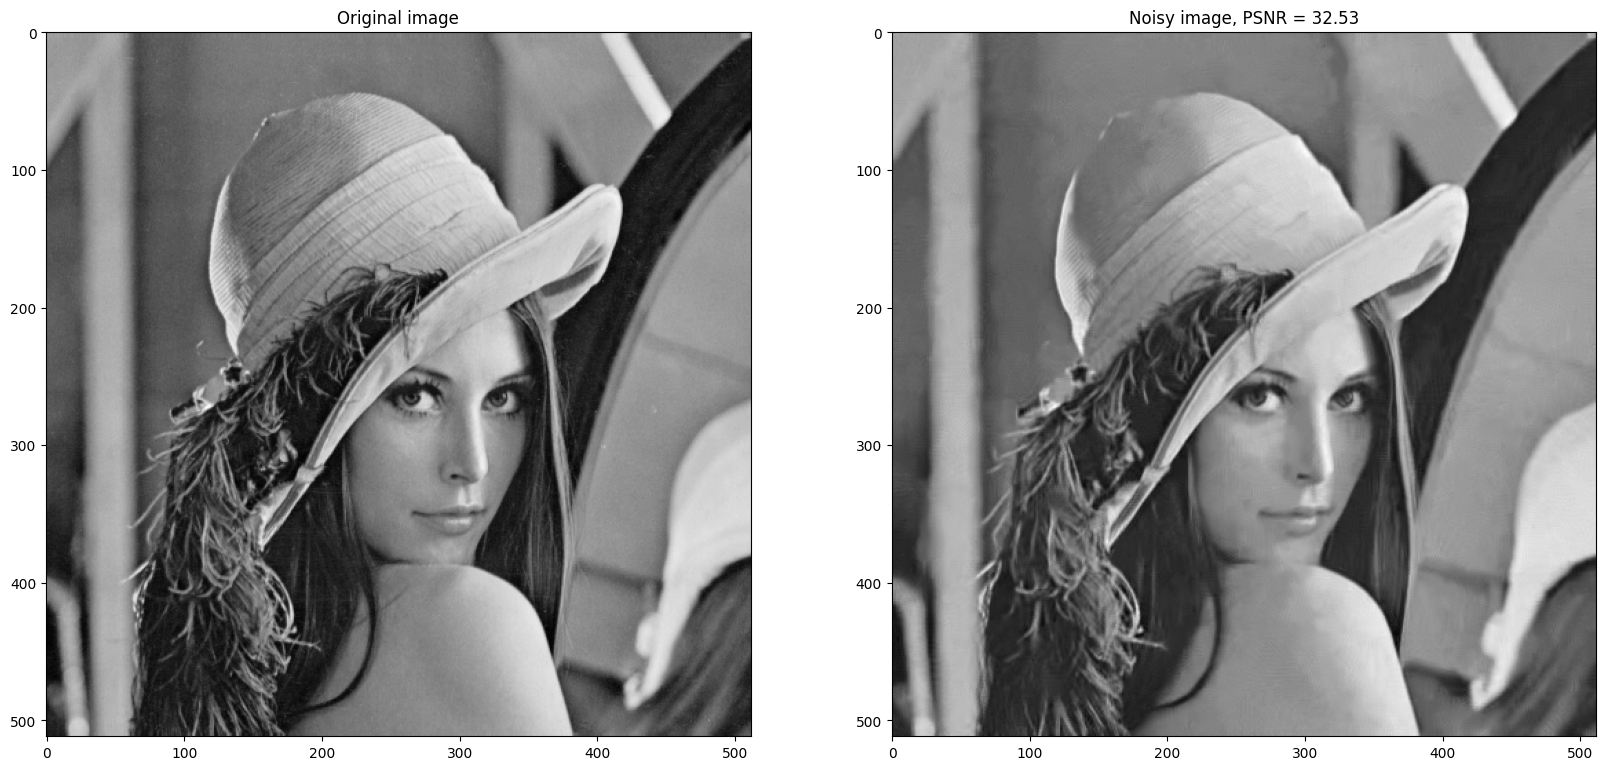

In [60]:
psnr_est = compute_psnr(img, basic_est)
plot_images(img, basic_est, psnr_est)

In [61]:
# Pad the basic estimate and the noisy image
basic_est_p = add_sym_pad(basic_est, pad_size)
noisy_img_p = add_sym_pad(noisy_img, pad_size)

final_est = BM3D_step2(noisy_img_p, basic_est_p)

# Remove the padding
final_est = final_est[pad_size:-pad_size, pad_size:-pad_size]

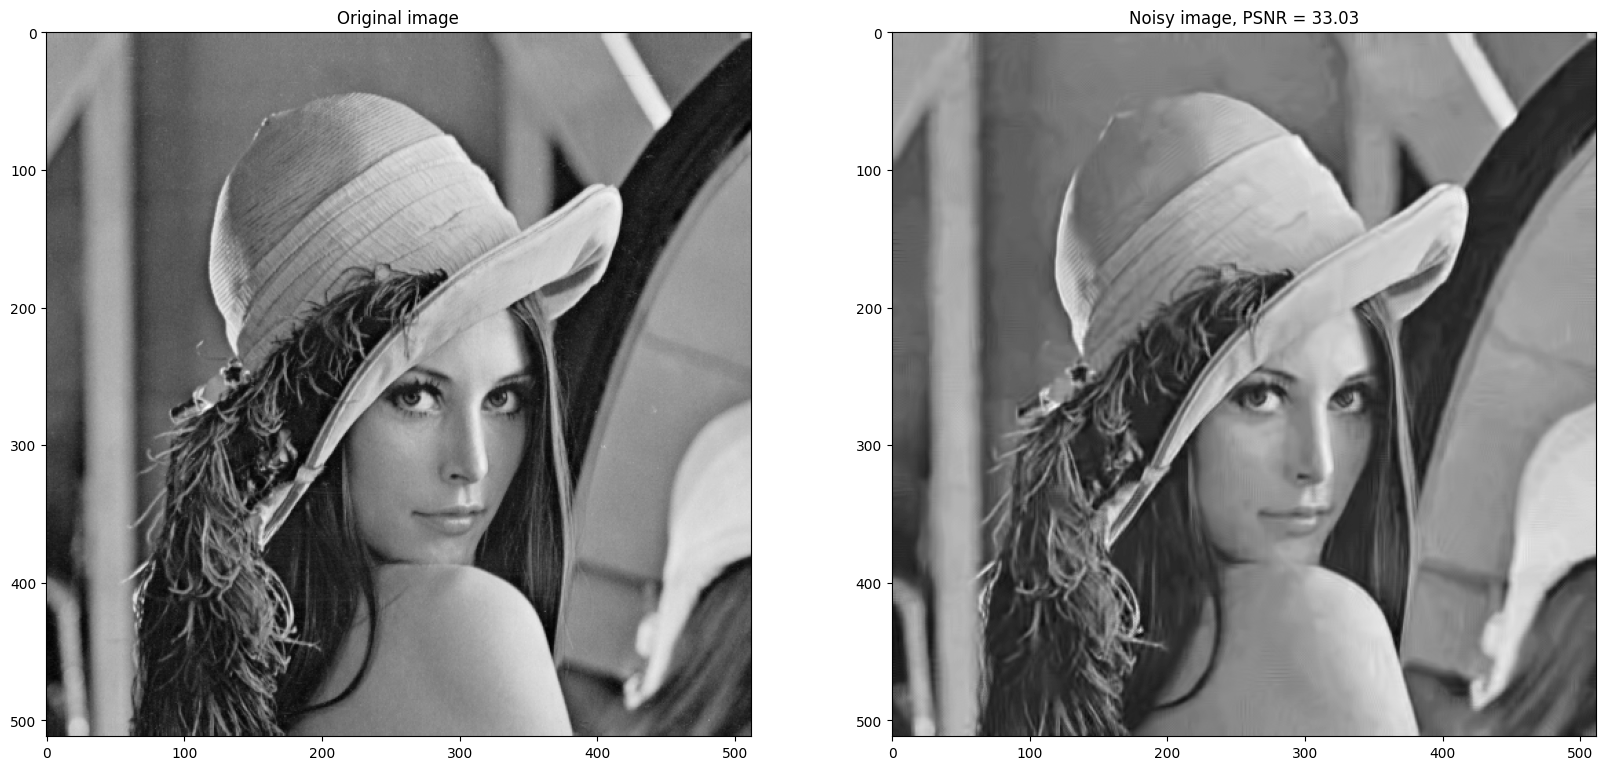

In [62]:
psnr_final = compute_psnr(img, final_est)
plot_images(img, final_est, psnr_final)